# Housing Price Prediction

I use the following pipeline:
1. **Feature engineering**
    - Drop outliers
    - Log-transform response `SalePrice`
    - Reduce skewness in predictor variables with Box-Cox transform
    - Replace categorical variables with one-hot encoding vectors (handles categorical NaNs)
    - Impute missing numerical variables with 0 and generate `nan_ind` cols
2. **Standardize** data with `StandardScaler`
3. **Train-Test split (70%-30%)**
4. **Model selection**
    - 3-fold cross-validation using the `training` set
    - Hyperparameter selection with Random Search or Grid Search (details in each respective section)
    - Refine grid selection (only for SVM, MLP; Random Forest and XGBoost were too time-consuming to train)
5. **Model evaluation**
    - Evaluate best cross-validated models on the test set.

# 1. Feature Engineering

In [36]:
#4.1 Load data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [37]:
# parse metadata
filename = "housing.csv"
df = pd.read_csv(filename, header=0)
print("Size of dataset: N={}, p={}".format(df.shape[0],df.shape[1]-2))
df.head(10)

Size of dataset: N=1460, p=79


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000



 mu = 180921.20 and sigma = 79415.29



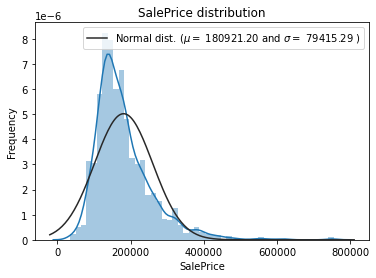

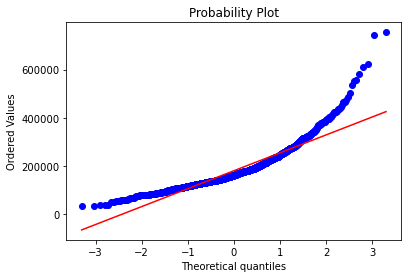

In [38]:
# check normality of target var
from scipy.stats import norm, probplot
import seaborn as sns

def check_normality(target,target_name="SalePrice"):
    sns.distplot(target, fit=norm);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(target)
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title(f'{target_name} distribution')

    #Get also the QQ-plot
    fig = plt.figure()
    res = probplot(target, plot=plt)
    plt.show()

target_name = "SalePrice"
check_normality(df[target_name], target_name)


 mu = 12.02 and sigma = 0.40



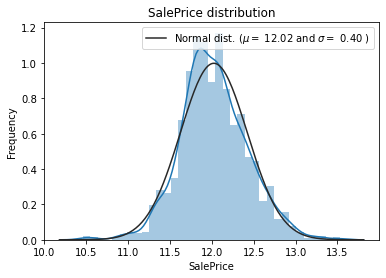

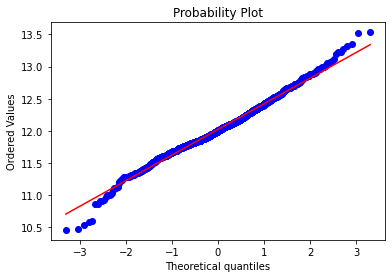

In [39]:
# drop outliers and log-transform for normality
df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<300000)].index) # Deleting outliers
df[target_name] = np.log1p(df[target_name])
check_normality(df[target_name], target_name)


In [40]:
# assess skewness of numerical features
from scipy.stats import skew
def check_skewness(df):
    numeric_feats = df.dtypes[df.dtypes != "object"].index

    # Check the skew of all numerical features
    skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    return skewness

skewness = check_skewness(df)
skewness.head(20)

,Skew
MiscVal,24.434913
PoolArea,15.932532
LotArea,12.560986
3SsnPorch,10.286510
LowQualFinSF,8.995688
KitchenAbvGr,4.480268
BsmtFinSF2,4.247550
ScreenPorch,4.114690
BsmtHalfBath,4.095895
EnclosedPorch,3.083987


In [43]:
from scipy.special import boxcox1p
from copy import copy

skew_thresh = 0.75
skewness = skewness[abs(skewness) > skew_thresh]

skewed_features = skewness.index
lam = 0.15
df_unskew = copy(df)
for feat in skewed_features:
    #all_data[feat] += 1
    df_unskew[feat] = boxcox1p(df[feat], lam)

check_skewness(df_unskew).head(10)

,Skew
PoolArea,15.515751
3SsnPorch,7.822202
LowQualFinSF,7.587831
MiscVal,5.501393
KitchenAbvGr,3.992521
BsmtHalfBath,3.940482
ScreenPorch,3.181641
BsmtFinSF2,2.616835
EnclosedPorch,2.158639
LotArea,0.710724


In [44]:
# check missingness
def check_missingness(df):
    all_data_na = (df.isnull().sum() / len(df)) * 100
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
    missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
    return missing_data

missing_df = check_missingness(df)
missing_df.head(20)

,Missing Ratio
PoolQC,99.588477
MiscFeature,96.296296
Alley,93.758573
Fence,80.727023
FireplaceQu,47.325103
LotFrontage,17.764060
GarageYrBlt,5.555556
GarageType,5.555556
GarageFinish,5.555556
GarageQual,5.555556


In [45]:
from copy import copy

# construct nan_ind columns for each col with missingness
cols = df.columns.values.tolist()
suffix_str = "_nan_ind"
ind_df = df[cols].isnull().astype(int).add_suffix(suffix_str)
# ind_df.head(10)
ind_df["Electrical_nan_ind"].unique()

# -> mygen() from: https://stackoverflow.com/questions/45121899/impute-missing-values-to-0-and-create-indicator-columns-in-pandas
def mygen(lst,suffix_str):
    for item in lst:
        yield item
        yield item + suffix_str

# interleave nan_ind cols with original df        
num_nas = ["LotFrontage","GarageYrBlt","MasVnrArea"]
df_dropped = copy(df)
for label, content in df_dropped[num_nas].items():
    # TO-DO: consider replacing with col mean for numerical values
    df_dropped[label] = df[label].fillna(0)
cat_labels = check_missingness(df_dropped).index.tolist()
df_dropped = df_dropped.fillna("None") # other nans are categorical
df_clean = pd.concat([df_dropped, ind_df], axis=1) \
        .reindex(list(mygen(cols,suffix_str)), axis=1)
remove_list = ["Id_nan_ind","SalePrice_nan_ind"]
df_clean = df_clean.drop(remove_list,axis=1)
df_clean.head(10)

,Id,MSSubClass,MSSubClass_nan_ind,MSZoning,MSZoning_nan_ind,LotFrontage,LotFrontage_nan_ind,LotArea,LotArea_nan_ind,Street,...,MiscVal_nan_ind,MoSold,MoSold_nan_ind,YrSold,YrSold_nan_ind,SaleType,SaleType_nan_ind,SaleCondition,SaleCondition_nan_ind,SalePrice
0,1,60,0,RL,0,65.0,0,8450,0,Pave,...,0,2,0,2008,0,WD,0,Normal,0,12.247699
1,2,20,0,RL,0,80.0,0,9600,0,Pave,...,0,5,0,2007,0,WD,0,Normal,0,12.109016
2,3,60,0,RL,0,68.0,0,11250,0,Pave,...,0,9,0,2008,0,WD,0,Normal,0,12.317171
3,4,70,0,RL,0,60.0,0,9550,0,Pave,...,0,2,0,2006,0,WD,0,Abnorml,0,11.849405
4,5,60,0,RL,0,84.0,0,14260,0,Pave,...,0,12,0,2008,0,WD,0,Normal,0,12.429220
5,6,50,0,RL,0,85.0,0,14115,0,Pave,...,0,10,0,2009,0,WD,0,Normal,0,11.870607
6,7,20,0,RL,0,75.0,0,10084,0,Pave,...,0,8,0,2007,0,WD,0,Normal,0,12.634606
7,8,60,0,RL,0,0.0,1,10382,0,Pave,...,0,11,0,2009,0,WD,0,Normal,0,12.206078
8,9,50,0,RM,0,51.0,0,6120,0,Pave,...,0,4,0,2008,0,WD,0,Abnorml,0,11.774528
9,10,190,0,RL,0,50.0,0,7420,0,Pave,...,0,1,0,2008,0,WD,0,Normal,0,11.678448


In [46]:
# "nan_ind" cols with zero-mean have no influence on regression
numeric_feats = df_clean.dtypes[df_clean.dtypes != "object"].index
print("Shape before dropping cols: {}".format(df_clean.shape))
drop_cols = []
for feat in numeric_feats:
    if(sum(df_clean[feat]) == 0 and suffix_str in feat):
        drop_cols.append(feat)
df_clean = df_clean.drop(drop_cols,axis=1)
print("Shape after dropping cols: {}".format(df_clean.shape))

Shape before dropping cols: (1458, 160)
Shape after dropping cols: (1458, 100)


In [47]:
# check missingness of cleaned dataset
check_missingness(df_clean) # sanity check -- expect no entries in this call

,Missing Ratio


In [48]:
# one-hot encoding with .get_dummies() to handle categorical cols
cols = df_clean.columns
num_cols = df_clean._get_numeric_data().columns
cat_cols = list(set(cols)-set(num_cols))
onehot_df = df_clean.copy()
for col in cat_cols:
    onehot_df = pd.get_dummies(onehot_df,columns=[col],prefix=[col]) # yields a one-hot vector
onehot_df.head(10)   

,Id,MSSubClass,LotFrontage,LotFrontage_nan_ind,LotArea,Alley_nan_ind,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,BsmtFinType2_Unf,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None
0,1,60,65.0,0,8450,1,7,5,2003,2003,...,1,0,0,0,0,1,0,0,0,1
1,2,20,80.0,0,9600,1,6,8,1976,1976,...,1,0,0,0,0,1,0,0,0,1
2,3,60,68.0,0,11250,1,7,5,2001,2002,...,1,0,0,0,0,1,0,0,0,1
3,4,70,60.0,0,9550,1,7,5,1915,1970,...,1,0,0,0,0,1,0,0,0,1
4,5,60,84.0,0,14260,1,8,5,2000,2000,...,1,0,0,0,0,1,0,0,0,1
5,6,50,85.0,0,14115,1,5,5,1993,1995,...,1,0,0,1,0,0,0,0,0,1
6,7,20,75.0,0,10084,1,8,5,2004,2005,...,1,0,0,0,0,1,0,0,0,1
7,8,60,0.0,1,10382,1,7,6,1973,1973,...,0,0,0,0,0,1,0,0,0,1
8,9,50,51.0,0,6120,1,7,5,1931,1950,...,1,0,0,0,0,1,0,0,0,1
9,10,190,50.0,0,7420,1,5,6,1939,1950,...,1,0,0,0,0,1,0,0,0,1


## 2. Standardize the data

In [49]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
y = onehot_df["SalePrice"].to_numpy()
X = onehot_df.drop("SalePrice",axis=1).to_numpy()
print("X with shape {}:\n{}".format(X.shape, X))
print("y with shape {}:\n{}".format(y.shape, y))

scaler = StandardScaler(with_mean=False)
X_std = scaler.fit_transform(X)

X with shape (1458, 322):
[[1.000e+00 6.000e+01 6.500e+01 ... 0.000e+00 0.000e+00 1.000e+00]
 [2.000e+00 2.000e+01 8.000e+01 ... 0.000e+00 0.000e+00 1.000e+00]
 [3.000e+00 6.000e+01 6.800e+01 ... 0.000e+00 0.000e+00 1.000e+00]
 ...
 [1.458e+03 7.000e+01 6.600e+01 ... 0.000e+00 0.000e+00 1.000e+00]
 [1.459e+03 2.000e+01 6.800e+01 ... 0.000e+00 0.000e+00 1.000e+00]
 [1.460e+03 2.000e+01 7.500e+01 ... 0.000e+00 0.000e+00 1.000e+00]]
y with shape (1458,):
[12.24769912 12.10901644 12.31717117 ... 12.49313327 11.86446927
 11.90159023]


## 3. Train-test split

In [51]:
from sklearn.model_selection import train_test_split

test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=test_size)

## 4. Model Selection
We will train the following 5 models using mean-squared error loss and 3-fold cross validation.
1. Random Forest
2. Gradient Boost,
3. K Nearest Neighbors
4. Support Vector Machines
5. MLP

## Note

Most of these model selection cells are very time-consuming. I don't recommend running them.

All the best models are defined and re-trained at the beginning of Section 4.5.

### 4.1 Random Forest: Randomized Search

Use `RandomizedSearchCV` with 3-fold cross-validation to determine hyperparameters for the model. Tips on `RandomizedSearchCV` [here](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74).

**Warning** -- This takes a long time to run (~40 minutes on my laptop). I have copied the best parameters from this Random Search in the Test Evaluation section, so you can skip calling this. 

In [122]:
# -> Train random forests
# sklearn docs for RFRegressor: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
  
n_estimators = [int(x) for x in np.linspace(100,1000, 10)] # what's a reasonable range of estimators?
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter = 100, cv = 3, verbose=2)

rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, total=   2.9s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, total=   2.9s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, total=   2.7s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False, total=  17.5s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False, total=  15.9s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False 
[CV]  n_estimators=600, min_

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 40.0min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   verbose=2)

In [123]:
# Report best model from random forest random search
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

`rf_random.best_params_ =
{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}
`
 
We could perform a restricted grid search for `n_estimators`, `min_samples_split`, `min_samples_leaf`, but we proceed with the hyperparameters from the random search in the interest of time.

### 4.2 Gradient Boost: Randomized Search

Similar to Random Forest, we use `RandomizedSearchCV` with 3-fold cross-validation to determine hyperparameters for the model.

**Warning** -- This takes a long time to run (~1 hour on my laptop). I have copied the best parameters from this Random Search in the Test Evaluation section, so you can skip calling this. 

In [129]:
# -> gradient tree boosting (XGBoost)
from sklearn.ensemble import GradientBoostingRegressor
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

n_estimators = [int(x) for x in np.linspace(100,1000, 10)] # what's a reasonable range of estimators?
learning_rate = [1e-4*10**num for num in range(3)] # orders of magnitude from [1e-4,1e-2]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
loss = ["ls","lad","huber"]
# bootstrap = [True, False]

random_grid_gb = {'n_estimators': n_estimators,
                  'learning_rate': learning_rate,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'loss': loss
                 }

gb = GradientBoostingRegressor()
# gb.get_params().keys()
gb_random = RandomizedSearchCV(estimator=gb, param_distributions=random_grid_gb, n_iter = 100, cv = 3, verbose=2)

gb_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=80, loss=ls, learning_rate=0.0001 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=80, loss=ls, learning_rate=0.0001, total=  17.4s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=80, loss=ls, learning_rate=0.0001 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.3s remaining:    0.0s


[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=80, loss=ls, learning_rate=0.0001, total=  19.0s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=80, loss=ls, learning_rate=0.0001 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=80, loss=ls, learning_rate=0.0001, total=  17.8s
[CV] n_estimators=900, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10, loss=ls, learning_rate=0.0001 
[CV]  n_estimators=900, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10, loss=ls, learning_rate=0.0001, total=  22.3s
[CV] n_estimators=900, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10, loss=ls, learning_rate=0.0001 
[CV]  n_estimators=900, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10, loss=ls, learning_rate=0.0001, total=  19.7s
[CV] n_estimators=900, min_samples_split

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 123.3min finished


RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_iter=100,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01],
                                        'loss': ['ls', 'lad', 'huber'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   verbose=2)

In [131]:
# Report best model from xgboost random search
gb_random.best_params_

{'n_estimators': 900,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 100,
 'loss': 'huber',
 'learning_rate': 0.01}

So we choose the following parameters for our Gradient Boost Model.

`gb_random.best_params_ =
{'n_estimators': 900,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 100,
 'loss': 'huber',
 'learning_rate': 0.01}
`
 
We could perform a restricted grid search for `n_estimators`, `min_samples_split`, `min_samples_leaf`, but we proceed with the hyperparameters from the random search in the interest of time.

### 4.3 KNN: Grid Search

We use `GridSearchCV` with 3-fold cross validation to determine the best `n_neighbors` for KNN regression. This is not a random search, so we sweep through a predefined grid of values.

In [228]:
# -> K-nearest neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn_list = [k for k in range(1,11)]

grid_knn = {'n_neighbors': knn_list}

knn = KNeighborsRegressor()
# gb.get_params().keys()
knn_grid = GridSearchCV(estimator=knn, param_grid=grid_knn, cv = 3, verbose=2)
knn_grid.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   0.2s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .................................... n_neighbors=1, total=   0.2s
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   0.2s
[CV] n_neighbors=2 ...................................................
[CV] .................................... n_neighbors=2, total=   0.2s
[CV] n_neighbors=2 ...................................................
[CV] .................................... n_neighbors=2, total=   0.2s
[CV] n_neighbors=2 ...................................................
[CV] .................................... n_neighbors=2, total=   0.2s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.2s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.2s
[CV] n_neighbors=3 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    5.7s finished


GridSearchCV(cv=3, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             verbose=2)

In [229]:
knn_grid.best_params_

{'n_neighbors': 7}

So we choose `n_neighbors=7` for our KNN model.

### 4.4 SVM: Grid Search

We use `GridSearchCV` with 3-fold cross validation to determine the best `C`,`kernel`, and `degree` for SVM regression. This is not a random search, so we sweep through a predefined grid of values.

In [232]:
# -> Kernel SVMs
from sklearn.svm import SVR
    
C_list = [C for C in range(10,201,25)]
kernel_list = ["linear","rbf","poly"]
print(C_list)

svm_grid = {
            'C': C_list,
            'kernel': kernel_list
            }

svm = SVR()
svm_grid = GridSearchCV(estimator=svm, param_grid=svm_grid, cv = 3, verbose=2)
svm_grid.fit(X_train,y_train)

[10, 35, 60, 85, 110, 135, 160, 185]
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] C=10, kernel=linear .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=10, kernel=linear, total=   9.2s
[CV] C=10, kernel=linear .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s remaining:    0.0s


[CV] .............................. C=10, kernel=linear, total=  12.4s
[CV] C=10, kernel=linear .............................................
[CV] .............................. C=10, kernel=linear, total=  29.4s
[CV] C=10, kernel=rbf ................................................
[CV] ................................. C=10, kernel=rbf, total=   0.2s
[CV] C=10, kernel=rbf ................................................
[CV] ................................. C=10, kernel=rbf, total=   0.2s
[CV] C=10, kernel=rbf ................................................
[CV] ................................. C=10, kernel=rbf, total=   0.2s
[CV] C=10, kernel=poly ...............................................
[CV] ................................ C=10, kernel=poly, total=   0.2s
[CV] C=10, kernel=poly ...............................................
[CV] ................................ C=10, kernel=poly, total=   0.2s
[CV] C=10, kernel=poly ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 13.7min finished


GridSearchCV(cv=3, estimator=SVR(),
             param_grid={'C': [10, 35, 60, 85, 110, 135, 160, 185],
                         'kernel': ['linear', 'rbf', 'poly']},
             verbose=2)

In [233]:
svm_grid.best_params_

{'C': 185, 'kernel': 'poly'}

So we use the polynomial kernel (`poly`) with `C=185`. We can finetune this search by specifying `degree` and a increasing the resolution of `C` grid.

In [237]:
# -> Kernel SVMs    
C_list_tight = [C for C in range(150,300,10)]
deg_list = [deg for deg in range(1,10,2)]
print(C_list)
print(deg_list)
svm_grid_poly = {
            'C': C_list_tight,
            'kernel': ['poly'],
            'degree': deg_list
            }
svm_grid_tight = GridSearchCV(estimator=svm, param_grid=svm_grid_poly, cv = 3, verbose=2)
svm_grid_tight.fit(X_train,y_train)

[10, 35, 60, 85, 110, 135, 160, 185]
[1, 3, 5, 7, 9]
Fitting 3 folds for each of 75 candidates, totalling 225 fits
[CV] C=150, degree=1, kernel=poly ....................................
[CV] ..................... C=150, degree=1, kernel=poly, total=   0.2s
[CV] C=150, degree=1, kernel=poly ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ..................... C=150, degree=1, kernel=poly, total=   0.2s
[CV] C=150, degree=1, kernel=poly ....................................
[CV] ..................... C=150, degree=1, kernel=poly, total=   0.2s
[CV] C=150, degree=3, kernel=poly ....................................
[CV] ..................... C=150, degree=3, kernel=poly, total=   0.1s
[CV] C=150, degree=3, kernel=poly ....................................
[CV] ..................... C=150, degree=3, kernel=poly, total=   0.1s
[CV] C=150, degree=3, kernel=poly ....................................
[CV] ..................... C=150, degree=3, kernel=poly, total=   0.1s
[CV] C=150, degree=5, kernel=poly ....................................
[CV] ..................... C=150, degree=5, kernel=poly, total=   0.1s
[CV] C=150, degree=5, kernel=poly ....................................
[CV] ..................... C=150, degree=5, kernel=poly, total=   0.1s
[CV] C=150, degree=5, kernel=poly ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:   29.9s finished


GridSearchCV(cv=3, estimator=SVR(),
             param_grid={'C': [150, 160, 170, 180, 190, 200, 210, 220, 230, 240,
                               250, 260, 270, 280, 290],
                         'degree': [1, 3, 5, 7, 9], 'kernel': ['poly']},
             verbose=2)

In [238]:
svm_grid_tight.best_params_

{'C': 260, 'degree': 7, 'kernel': 'poly'}

So we use the polynomial kernel (`poly`) with `C=260` and `degree=7`.

### 4.5 MLP: Grid Search over Depth/Width
The `KerasRegressor` wrapper allows us to perform a grid search on the MLP hyperparameters. I choose to vary the following:

- `depth`: number of hidden layers
- `width`: number of nuerons per layer
- `lr`: learning rate (vary from `1e-4` to `1e-5`)
- `activ`: activation (either 'relu' or 'sigmoid')
    - For now, every layer has the same activation
    - We will introduce more heterogeneity in another grid search


In [ ]:
# create a Keras wrapper for RandomCV

# from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import layers, activations, optimizers
import tensorflow as tf
from tensorflow import keras

# get consistent state for random seed
seed=7
np.random.seed(seed)

def mlp_sweep_gen(p=X_train.shape[1], depth=3,width=3,lr=0.01,activ='relu',loss="mse",):
    """
    : wrapper to sweep depth, width, lr, activation of MLP
    """
    opt = optimizers.Adam(learning_rate=lr)
    model = keras.Sequential()
    for i in range(depth):
        if (i==0):
            model.add(layers.Dense(units=width, input_shape=(p,), activation=activ))
        else:
            model.add(layers.Dense(units=width, activation=activ))
    model.add(layers.Dense(units=1)) # output is predictor for SalePrice
    model.compile(optimizer=opt,loss=loss,metrics=["mse"])
    return model

# this was initially a false start. I wanted to sweep width/depth using the grid, but the 
depth_iter = range(3,10,2)
width_iter = range(3,10,2)
mlp_result_dict = dict()
# holding batch_size, epochs constant. We will refine this after the grid search
for depth in depth_iter:
    for width in width_iter:
        print('width: {} // depth: {}'.format(width, depth))
        param_grid_mlp = {
                           'width': [width],
                           # 'depth': np.linspace(1,8,2), # we have to fix the parameter depth
                           'depth': [depth],
                           'activ': ["relu"],
                            'lr': [1e-4*10**num for num in range(0,3)]
                         }

        mlp = keras.wrappers.scikit_learn.KerasRegressor(build_fn=mlp_sweep_gen, batch_size=32, epochs=50,verbose=1)
        mlp_grid = GridSearchCV(estimator=mlp, param_grid=param_grid_mlp, cv = 3, verbose=0)

        mlp_grid.fit(X_train,y_train)
        mlp_result_dict['d{}w{}'.format(depth,width)] = mlp_grid

width: 3 // depth: 3
Epoch 1/50
22/22 [==============================] - 0s 2ms/step - loss: 145.2992 - mse: 145.2992
Epoch 2/50
22/22 [==============================] - 0s 2ms/step - loss: 145.2462 - mse: 145.2462
Epoch 3/50
22/22 [==============================] - 0s 1ms/step - loss: 145.1932 - mse: 145.1932
Epoch 4/50
22/22 [==============================] - 0s 2ms/step - loss: 145.1402 - mse: 145.1402
Epoch 5/50
22/22 [==============================] - 0s 2ms/step - loss: 145.0873 - mse: 145.0873
Epoch 6/50
22/22 [==============================] - 0s 2ms/step - loss: 145.0343 - mse: 145.0343
Epoch 7/50
22/22 [==============================] - 0s 1ms/step - loss: 144.9814 - mse: 144.9814
Epoch 8/50
22/22 [==============================] - 0s 2ms/step - loss: 144.9285 - mse: 144.9285
Epoch 9/50
22/22 [==============================] - 0s 2ms/step - loss: 144.8756 - mse: 144.8756
Epoch 10/50
22/22 [==============================] - 0s 2ms/step - loss: 144.8228 - mse: 144.8228
Epoch 11

In [165]:
# -> Assess results of the grid search
best_result_key = None
best_result_mse = 1e3
best_result = None
for key, mlp_grid_result in mlp_result_dict.items():
    y_hat = mlp_grid_result.predict(X_train)
    mse = mean_squared_error(y_hat, y_train)
    if mse < best_result_mse:
        best_result_mse = mse
        best_result_key = key
        best_result= mlp_grid_result
    print(f"{key}: mse={mse}")
print('Best model={} with mse={}'.format(best_result_key, best_result_mse))

32/32 [==============================] - 0s 2ms/step
d3w3: mse=0.1679970769314299
32/32 [==============================] - 0s 1ms/step
d3w5: mse=0.03575578701586685
32/32 [==============================] - 0s 2ms/step
d3w7: mse=2.7607585119464986
32/32 [==============================] - 0s 2ms/step
d3w9: mse=0.16817998072585033
32/32 [==============================] - 0s 2ms/step
d5w3: mse=0.16800182393251434
32/32 [==============================] - 0s 2ms/step
d5w5: mse=0.16799892698600322
32/32 [==============================] - 0s 2ms/step
d5w7: mse=0.018847475130685513
32/32 [==============================] - 0s 1ms/step
d5w9: mse=0.016453948948161275
32/32 [==============================] - 0s 2ms/step
d7w3: mse=0.16800421537093177
32/32 [==============================] - 0s 2ms/step
d7w5: mse=0.11642788761098093
32/32 [==============================] - 0s 1ms/step
d7w7: mse=0.014316827073604946
32/32 [==============================] - 0s 2ms/step
d7w9: mse=0.010041843614656877
32

### 4.5 MLP (cont.): Grid Search over Activation function

Now let's fix the network dimensions (`depth=7`,`width=9`) and try different combinations of `relu` and `sigmoid`.

In [189]:
def mlp_sweep_activ(p=X_train.shape[1], depth=7,width=9,lr=0.01,activ_list=["relu" for i in range(7)],loss="mse",):
    """
    : wrapper to sweep depth, width, lr, activation of MLP
    """
    opt = optimizers.Adam(learning_rate=lr)
    model = keras.Sequential()
    for i in range(depth):
        if (i==0):
            model.add(layers.Dense(units=width, input_shape=(p,), activation=activ_list[i]))
        else:
            model.add(layers.Dense(units=width, activation=activ_list[i]))
    model.add(layers.Dense(units=1)) # output is predictor for SalePrice
    model.compile(optimizer=opt,loss=loss,metrics=["mse"])
    return model

depth = best_result.best_params_["depth"]
width = best_result.best_params_["width"]
lr = best_result.best_params_["lr"]

activ_list = [ ['relu']*(depth-outer) + ['sigmoid']*outer for outer in range(depth) ] + [ ['sigmoid']*(depth-outer) + ['relu']*outer for outer in range(depth) ]
print(activ_list)

act_params = {
              'activ_list': activ_list,
              'depth': [depth],
              'width':[width],
              'lr':[lr]
             }

mlp_act = keras.wrappers.scikit_learn.KerasRegressor(build_fn=mlp_sweep_activ, batch_size=32, epochs=50, verbose=1)
act_grid = GridSearchCV(estimator=mlp_act, param_grid=act_params, cv = 3, verbose=0)

act_grid.fit(X_train,y_train)

[['relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu'], ['relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'sigmoid'], ['relu', 'relu', 'relu', 'relu', 'relu', 'sigmoid', 'sigmoid'], ['relu', 'relu', 'relu', 'relu', 'sigmoid', 'sigmoid', 'sigmoid'], ['relu', 'relu', 'relu', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid'], ['relu', 'relu', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid'], ['relu', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid'], ['sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid'], ['sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'relu'], ['sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'relu', 'relu'], ['sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'relu', 'relu', 'relu'], ['sigmoid', 'sigmoid', 'sigmoid', 'relu', 'relu', 'relu', 'relu'], ['sigmoid', 'sigmoid', 'relu', 'relu', 'relu', 'relu', 'relu'], ['sigmoid', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu']]
Epoch 1/50
22/22 [======================

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000002A08998EC08>, as the constructor either does not set or modifies parameter activ_list

In [194]:
print(act_grid.best_params_)

{'activ_list': ['relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu'], 'depth': 7, 'lr': 0.01, 'width': 9}


An all-`relu` model does best, so we train this network to a larger number of epochs.

In [208]:
# assess the convergence of this model for a few lrs
lr_list = [1e-4*10**i for i in range(3)]
lr_models = []
for lr in lr_list:
    mlp_lr_model = mlp_sweep_activ(lr=lr) # default args yield best performance
    mlp_lr_model.fit(X_train,y_train,batch_size=32,epochs=200)
    lr_models.append(mlp_lr_model)

Epoch 1/200
32/32 [==============================] - 0s 2ms/step - loss: 167.5352 - mse: 167.5352
Epoch 2/200
32/32 [==============================] - 0s 2ms/step - loss: 161.2104 - mse: 161.2104
Epoch 3/200
32/32 [==============================] - 0s 3ms/step - loss: 156.7601 - mse: 156.7601
Epoch 4/200
32/32 [==============================] - 0s 2ms/step - loss: 153.4019 - mse: 153.4019
Epoch 5/200
32/32 [==============================] - 0s 3ms/step - loss: 148.3807 - mse: 148.3807
Epoch 6/200
32/32 [==============================] - 0s 2ms/step - loss: 137.1925 - mse: 137.1925
Epoch 7/200
32/32 [==============================] - 0s 2ms/step - loss: 129.2416 - mse: 129.2416
Epoch 8/200
32/32 [==============================] - 0s 2ms/step - loss: 121.1872 - mse: 121.1872
Epoch 9/200
32/32 [==============================] - 0s 2ms/step - loss: 112.7868 - mse: 112.7868
Epoch 10/200
32/32 [==============================] - 0s 2ms/step - loss: 100.9622 - mse: 100.9622
Epoch 11/200
32/32 

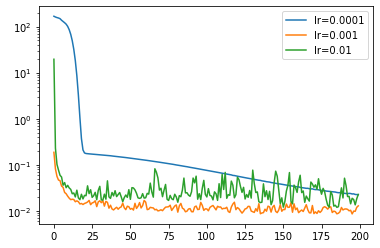

In [216]:
fig,ax = plt.subplots()
ep_list = [val for val in range(200)]
for model,i in zip(lr_models,range(3)):
    ax.semilogy(ep_list,model.history.history["loss"],label=f"lr={lr_list[i]}")
plt.legend()
plt.show()

So we will use the model trained with $lr=0.001$ as our final model.

In summary, we will use the MLP with these hyperparameters:

- `depth-7`
- `width=9`
- `lr=0.001`
- `activ=relu` (all layers)

## 5 Test Set Evaluation

Assess the best models from `RandomSearchCV` and `GridSearchCV` on the test set.

In [55]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from mlp_generator import mlp_sweep_activ

# define models
rf_model = RandomForestRegressor(n_estimators=1000,min_samples_split=2,min_samples_leaf=2,max_features='auto',max_depth=None,bootstrap=True)
xg_model = GradientBoostingRegressor(n_estimators=900,min_samples_split=5, min_samples_leaf=4, max_features='sqrt', max_depth=100, loss='huber', learning_rate=0.01)
knn_model = KNeighborsRegressor(n_neighbors=7)
svm_model = SVR(C=260,kernel="poly",degree=7)
mlp_model = mlp_sweep_activ(X_train.shape[1],depth=7, width=9, activ_list=['relu']*7, lr=0.001)

all_best_models = [rf_model, xg_model, knn_model, svm_model, mlp_model]

In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

test_mse_list = []
test_mae_list = []
y_orig = np.expm1(y_test)
model_names = ["RF", "XGBoost", "KNN", "SVM", "MLP"]
for model, i in zip(all_best_models, range(len(model_names))):
    print(f"--- Fit and test {model_names[i]} ---")
    if i < len(all_best_models)-1:
        model.fit(X_train,y_train)
    else:
        model.fit(X_train,y_train,epochs=200)
    y_hat = model.predict(X_test)
    mse = mean_squared_error(y_hat, y_test)
    y_hat_orig = np.expm1(y_hat)
    mae_orig = mean_absolute_error(y_orig,y_hat_orig)
    test_mse_list.append(mse)
    test_mae_list.append(mae_orig)
    print("--> For {}: Test MSE = {:5.4f} // Test MAE = ${:7.2f} ".format(model_names[i], mse, mae_orig))

--- Fit and test RF ---
--> For RF: Test MSE = 0.0238 // Test MAE = $16827.79 
--- Fit and test XGBoost ---
--> For XGBoost: Test MSE = 0.0212 // Test MAE = $15508.90 
--- Fit and test KNN ---
--> For KNN: Test MSE = 0.0499 // Test MAE = $26666.83 
--- Fit and test SVM ---
--> For SVM: Test MSE = 0.0173 // Test MAE = $13468.65 
--- Fit and test MLP ---
Epoch 1/200
32/32 [==============================] - 0s 1ms/step - loss: 191.7375 - mse: 191.7375
Epoch 2/200
32/32 [==============================] - 0s 2ms/step - loss: 122.2181 - mse: 122.2181
Epoch 3/200
32/32 [==============================] - 0s 2ms/step - loss: 93.6168 - mse: 93.6168
Epoch 4/200
32/32 [==============================] - 0s 2ms/step - loss: 49.8432 - mse: 49.8432
Epoch 5/200
32/32 [==============================] - 0s 1ms/step - loss: 5.9126 - mse: 5.9126
Epoch 6/200
32/32 [==============================] - 0s 2ms/step - loss: 0.3020 - mse: 0.3020
Epoch 7/200
32/32 [==============================] - 0s 2ms/step - lo

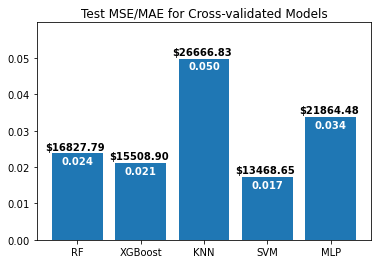

In [61]:
fig, axs = plt.subplots()
x = [i for i in range(len(test_mse_list))]
axs.bar(x,height=test_mse_list)
plt.xticks(x,model_names)
for i, val, doll_val in zip(range(len(test_mse_list)), test_mse_list, test_mae_list):
    axs.text(i-.25, val-3e-3, "{:4.3f}".format(val), fontweight='bold', color="white")
    axs.text(i-.5, val+1e-3, "${:6.2f}".format(doll_val), fontweight='bold')
axs.set_ylim([0,max(test_mse_list)+.01])
plt.title("Test MSE/MAE for Cross-validated Models")
plt.show()

In [62]:
y_err_perc_min = np.min(test_mae_list)/np.mean(y_orig)*100
y_err_perc_max = np.max(test_mae_list)/np.mean(y_orig)*100
print("Our MAE is within {:3.1f}% to {:3.1f}% of the average test set SalePrice (${:6.2f})".format(y_err_perc_min,y_err_perc_max,np.mean(y_orig)))

Our MAE is within 7.7% to 15.3% of the average SalePrice ($174624.23)


## Conclusions

- **Note**: The reported MSE values (in white) are on the log-transformed `SalePrice`.
    - I include the Mean Absolute Error (MAE, in black) on the original `SalePrice`. This allows for an interpretible result in a dollar amount.
- SVM performs best with XGBoost coming in a close second.
    - The prediction accuracy is reasonably good. A down payment on a mortgage is typically ~10% of the `SalePrice`, and our best models predict with accuracy closer than 10% of the average sale price.
    - RF and XGBoost could have been improved by using a restricted `GridSearchCV`. I did not refine these models after the `RandomSearchCV` since they are computationally costly to train.
    - The MLP's performance is slightly worse than most other methods (except KNN).
        - I could have tried deeper/wider (>9 layers/neurons) networks, but the performance is reasonable despite the shallowness/narrowness of the model.